### <b>Pre Processing</b> ###
##### <i>Steps:</i>
- Remove punctuations, numbers etc and using regex to only obtain words (i.e. made up of alphabets only)
- Stop words removal using gensim's stopwords and addition of other stop words based on our evaluation
- Add POS tagging for each word and lemmatize the word if word is tagged as a 'a', 'r', 'n', 'v'

In [228]:
# Import all libraries
import numpy as np
import pandas as pd

import nltk
from nltk import word_tokenize, pos_tag
from nltk.util import ngrams
from nltk.corpus import PlaintextCorpusReader
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from copy import deepcopy
import re
import string

import gensim
from gensim.parsing.preprocessing import STOPWORDS
from gensim.parsing.porter import PorterStemmer
from gensim.similarities import MatrixSimilarity
from gensim import corpora
from gensim import similarities
from gensim import models

from itertools import chain

# Sample K-Means Clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler


# Hierarchical clustering
import scipy.cluster.hierarchy as sch

# tfidf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import matplotlib.pyplot as plt
import seaborn as sns

import pickle
from joblib import dump, load

from tqdm import tqdm

# to ignore warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1129)>


## Note: To get all outputs, refer to below code and run it (skip the next few cells)

In [229]:
# Reading the textfiles
corpus = PlaintextCorpusReader('court-cases-dataset', '.+\.txt', encoding='latin-1')

# Define a set of stopwords
stop_words = set(STOPWORDS)

# manually include stopwords
stop_words.update(["state",
    "law",
    "judgment",
    "act",
    "petitioner",
    "decision",
    "contract",
    "writ",
    "petition",
    "file",
    "statute",
    "claim",
    "order",
    "cause",
    "jurisdiction",
    "grant",
    "consideration",
    "property",
    "defendant",
    "federal",
    "power",
    "certiorari",
    "opinion",
    "motion",
    "appeal",
    "company",
    "plaintiff",
    "bring",
    "case",
    "certain",
    "come",
    "court",
    "et",
    "fact",
    "general",
    "hold",
    "include",
    "like",
    "particular",
    "present",
    "question",
    "right",
    "section",
    "shall",
    "think",
    "year"])

# Define a WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

In [230]:
def preprocessing(corpus):
    tokenized_1gram = []
    # Tokenize into 1-grams (individual words) and 2-grams (word pairs)
    for file_id in corpus.fileids():
        text = corpus.raw(file_id)
        
        # remove punctuations
        text_np = [w for w in text.split() if re.search('^[a-z]+$', w)]
        
        # remove stop words
        text_stopped = [w for w in text_np if w not in stop_words]
        text_joint = ' '.join(text_stopped)
        
        # POS tag, Convert to lowercase and tokenize
        inner_lst=[]
        for word, tag in pos_tag(word_tokenize(text_joint.lower())):
            
            wntag = tag[0].lower()
            wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
            if not wntag:
                lemma = word
                
            else:
                lemma = lemmatizer.lemmatize(word, wntag)

            inner_lst.append(lemma)
            # inner_lst = [w for w in inner_lst if w not in stop_words]         
        # # Lemmatize 1-grams 
        # tokens_1gram = [lemmatizer.lemmatize(token) for token in tokens_1gram]
        
        tokenized_1gram.append([w for w in inner_lst if w not in stop_words])
    
    return tokenized_1gram


In [231]:
tokenized_1gram = preprocessing(corpus)

In [232]:
# Join words together for frequency computations
tokenized_1gram_joint = [word for sublist in tokenized_1gram for word in sublist]

# Compute frequency of each word
fdist = nltk.FreqDist(tokenized_1gram_joint)

In [233]:
# To display the word frequencies
most_common_words = fdist.most_common(200)  
most_common_words[:10]

[('require', 65773),
 ('provide', 59979),
 ('time', 56970),
 ('action', 55575),
 ('issue', 53181),
 ('rule', 52652),
 ('tax', 51963),
 ('provision', 51765),
 ('evidence', 50197),
 ('public', 47092)]

- Save processed corpus

In [234]:
with open("processed_tokens_unigram.pkl", "wb") as file:
    pickle.dump(tokenized_1gram, file)

- Load processed corpus

In [235]:
with open("processed_tokens_unigram.pkl", "rb") as file:
    tokenized_1gram = pickle.load(file)


In [236]:
# for processing for LDA
def docs2vecs(docs, dictionary):
    # docs is a list of documents returned by corpus2docs.
    # dictionary is a gensim.corpora.Dictionary object.
    vecs1 = [dictionary.doc2bow(doc) for doc in docs]
    return vecs1

# obtain law doc
law_docs = deepcopy(tokenized_1gram)

In [237]:
%%time
# conversion to vectors 
dictionary = gensim.corpora.Dictionary(tokenized_1gram)
law_vecs = docs2vecs(tokenized_1gram, dictionary)

CPU times: user 14.2 s, sys: 4.82 s, total: 19 s
Wall time: 21.2 s


- Conversion of matrix to Tfidf vectors

In [238]:
%%time


# Use TfidfVectorizer to generate a vector representation of the text

# Since TfidfVectorizer does not work on already tokenized text
# Define dummy function and preprocessor
def dummy_fun(doc):
    return doc

# Pass dummy function and preprocessor into TfidfVectorizer object
tfidf_vect = TfidfVectorizer(analyzer='word', tokenizer=dummy_fun, preprocessor=dummy_fun, token_pattern=None)
all_tfidf_vectors = tfidf_vect.fit_transform(tokenized_1gram)
   

CPU times: user 3.76 s, sys: 489 ms, total: 4.25 s
Wall time: 4.55 s


In [239]:
tfidf_vect.get_feature_names_out()[150:160]

array(['abridgment', 'abro', 'abroad', 'abrogate', 'abrogated',
       'abrogates', 'abrogating', 'abrogation', 'abrogative', 'abrupt'],
      dtype=object)

- save all_tfidf_vectors matrix and TfidfVectorizer for easy reloading

In [240]:
dump(tfidf_vect, 'tfidf_vect_unigram.joblib', protocol=4)
np.save('all_tfidf_vectors_unigram.npy', all_tfidf_vectors)

# For loading of outputs generated from above code
- for reloading of TfidfVectorizer and its matrix 

In [241]:
def dummy_fun(doc):
    return doc

# loading of the model
tfidf_vect = load('tfidf_vect_unigram.joblib')

# loading of tfidf_vectors
all_tfidf_vectors = np.load('all_tfidf_vectors_unigram.npy', allow_pickle=True)

In [242]:
# After reloading all_tfidf_vectors, to convert back to its original format, run the below code

X = all_tfidf_vectors

# Check if X is a numpy scalar containing the sparse matrix
if isinstance(X, np.ndarray) and X.dtype == object and hasattr(X.item(), 'shape'):
    sparse_matrix = X.item()
    print(sparse_matrix.shape)


(15000, 55474)


## Hierarchical Clustering
#### Steps:
- SVD for dimensionality reduction
- Plotting dendogram to identify ideal number of clusters
- Creating a model (Using agglomerative clustering) with optimal number of clusters as identified by the dendogram
- Evaluating the results of the hierarchical model clustering using silhouette scores and correlation coefficient

- Using SVD to reduce number of dimensions

In [243]:
%%time

# Assuming X is your tf-idf matrix
svd = TruncatedSVD(n_components=100)  # Reduce to 100 dimensions, adjust as needed
X_reduced = svd.fit_transform(sparse_matrix)

CPU times: user 11.7 s, sys: 13.5 s, total: 25.2 s
Wall time: 5.06 s


In [244]:
%%time

# Cosine similarity
similarity = cosine_similarity(X_reduced)

# Convert similarity to distance
dist = 1 - similarity

CPU times: user 2.71 s, sys: 2.59 s, total: 5.29 s
Wall time: 2.56 s


- Determine number of clusters based on dendogram - unigram

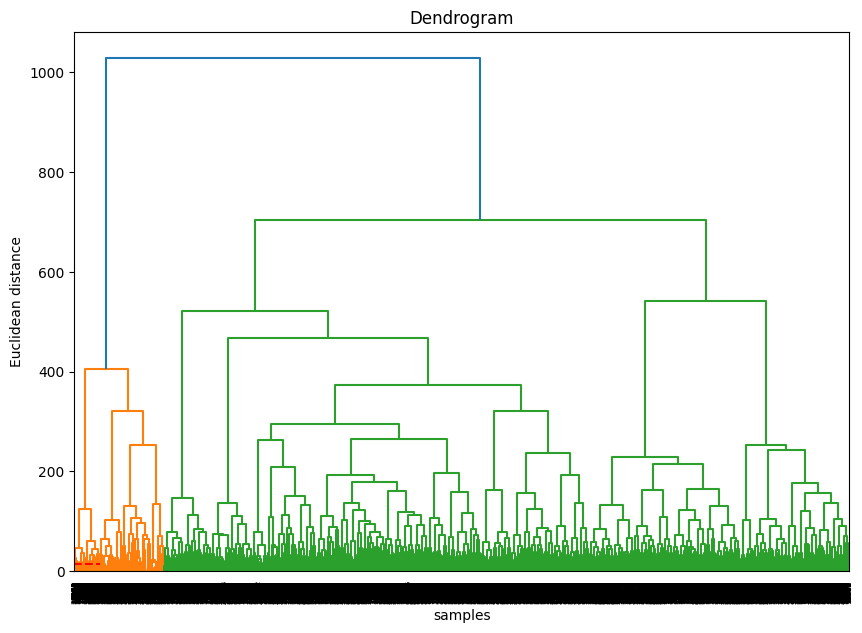

CPU times: user 10min 42s, sys: 55 s, total: 11min 37s
Wall time: 12min 12s


In [245]:
%%time

# Dendogram to find the optimal number of clusters under PCA dataset
plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(sch.linkage(dist,method = 'ward'))
plt.hlines(15,0,5000,colors='r',linestyle='--') #Red line at Euclidean distance = 15 as that is the maximum distance between both blue lines
plt.title('Dendrogram')
plt.xlabel('samples')
plt.ylabel('Euclidean distance')
plt.show()


- Creating a model (n_clusters = 3)

In [246]:
%%time

from sklearn.cluster import AgglomerativeClustering

n_clusters = 3  # Adjust as needed
clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
labels = clustering.fit_predict(dist)

CPU times: user 8min 28s, sys: 12.1 s, total: 8min 40s
Wall time: 8min 48s


- Evaluation of results (Silhouette scores)

Silhouette score of cluster by Hierachical Clustering : 0.10563709435471362
CPU times: user 13min 41s, sys: 44.4 s, total: 14min 25s
Wall time: 2min 38s


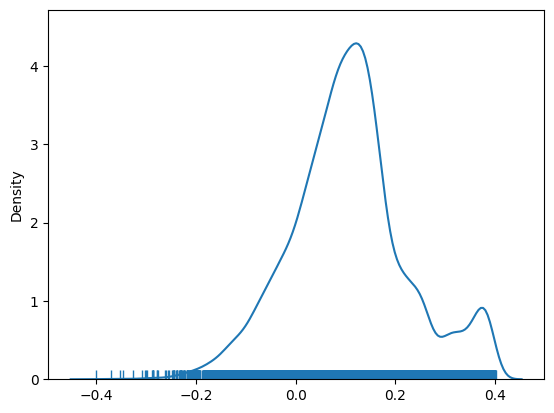

In [247]:
%%time

# Evaluate results of Hierachical Clustering
sh_score_Clus = silhouette_score(dist, labels)
print("Silhouette score of cluster by Hierachical Clustering :",sh_score_Clus)
sh_scores_Clus = silhouette_samples(dist, labels)
p4=sns.distplot(sh_scores_Clus, hist=False, rug=True, label = 'HC');

- Evaluation of results (Coeffcient correlation)

In [248]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist

Z = linkage(dist, 'ward')

# Calculate the cophenetic correlation coefficient
coph_corr, coph_dists = cophenet(Z, pdist(dist))
print(f"Cophenetic Correlation Coefficient: {coph_corr:.3f}")

Cophenetic Correlation Coefficient: 0.633


In [249]:
from scipy.cluster.hierarchy import fcluster

# Assign data points to clusters based on the dendrogram
max_d = 10  # distance where you want to cut the dendrogram
clusters = fcluster(Z, max_d, criterion='distance')

print(clusters)

[1867 2915  713 ... 3758 2096  712]


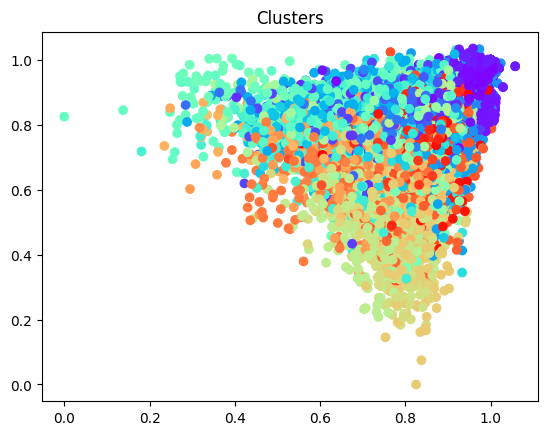

In [250]:
plt.scatter(dist[:,0], dist[:,1], c=clusters, cmap='rainbow')
plt.title('Clusters')
plt.show()

- For saving the model

In [251]:
dump(clustering, 'agglomerative_model_3.joblib')

['agglomerative_model_3.joblib']

## Using k-means clustering

#### Steps:
- Obtain optimal number of clusters based on the elbow method (from a range of 1 to 30)


100%|██████████| 28/28 [11:55<00:00, 25.56s/it]


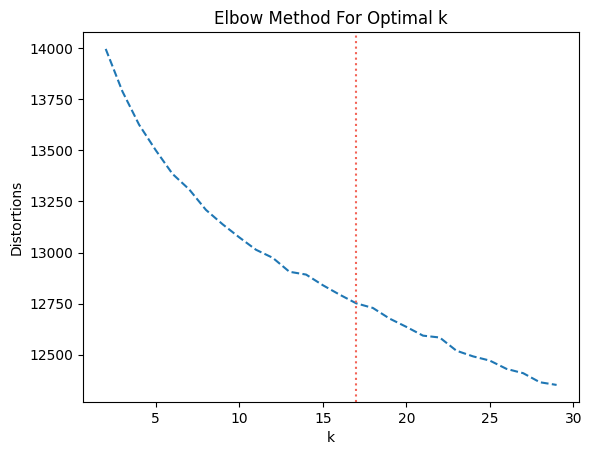

In [252]:
# Elbow curve to find optimal K 
Sum_of_squared_distances = []
K = range(2,30)
for k in tqdm(K):
    km = KMeans(init="k-means++", n_clusters=k, max_iter = 300, n_init = 10,random_state=2023)
    km = km.fit(sparse_matrix)
    Sum_of_squared_distances.append(km.inertia_)

ax = sns.lineplot(x=K, y=Sum_of_squared_distances)
ax.lines[0].set_linestyle("--")

# Add a vertical line to show the optimum number of clusters (to revise)
plt.axvline(17, color='#F26457', linestyle=':')

plt.xlabel('k')
plt.ylabel('Distortions')
plt.title('Elbow Method For Optimal k')
plt.show()

In [253]:
# Silhouette Score 
def get_silhouette_score(sparse_matrix, k):
    for n_clusters in tqdm(range(2, k)):
        clusterer = KMeans(init="k-means++", n_clusters=n_clusters, max_iter = 300, n_init = 10, random_state=2023)
        y = clusterer.fit_predict(sparse_matrix)
     
        message = "For n_clusters = {} The average silhouette_score is: {}"
        print(message.format(n_clusters, silhouette_score(sparse_matrix, y)))

get_silhouette_score(sparse_matrix, 30)

  4%|▎         | 1/28 [00:30<13:42, 30.44s/it]

For n_clusters = 2 The average silhouette_score is: 0.029580337346123156


  7%|▋         | 2/28 [01:01<13:21, 30.83s/it]

For n_clusters = 3 The average silhouette_score is: 0.032374328545366496


 11%|█         | 3/28 [01:34<13:18, 31.96s/it]

For n_clusters = 4 The average silhouette_score is: 0.02525246689389516


 14%|█▍        | 4/28 [02:09<13:08, 32.86s/it]

For n_clusters = 5 The average silhouette_score is: 0.027486089130979236


 18%|█▊        | 5/28 [02:45<13:03, 34.06s/it]

For n_clusters = 6 The average silhouette_score is: 0.029303260170769535


 21%|██▏       | 6/28 [03:21<12:41, 34.63s/it]

For n_clusters = 7 The average silhouette_score is: 0.03073958164769962


 25%|██▌       | 7/28 [03:58<12:29, 35.68s/it]

For n_clusters = 8 The average silhouette_score is: 0.03254704313240183


 29%|██▊       | 8/28 [04:39<12:22, 37.13s/it]

For n_clusters = 9 The average silhouette_score is: 0.033794165044207285


 32%|███▏      | 9/28 [05:19<12:05, 38.21s/it]

For n_clusters = 10 The average silhouette_score is: 0.03487047632964727


 36%|███▌      | 10/28 [06:03<12:00, 40.00s/it]

For n_clusters = 11 The average silhouette_score is: 0.03268196758879374


 39%|███▉      | 11/28 [06:48<11:43, 41.38s/it]

For n_clusters = 12 The average silhouette_score is: 0.036503020997226014


 43%|████▎     | 12/28 [07:35<11:31, 43.21s/it]

For n_clusters = 13 The average silhouette_score is: 0.035088017511960175


 46%|████▋     | 13/28 [08:21<11:01, 44.12s/it]

For n_clusters = 14 The average silhouette_score is: 0.034762490228730736


 50%|█████     | 14/28 [09:11<10:40, 45.72s/it]

For n_clusters = 15 The average silhouette_score is: 0.03469774661723298


 54%|█████▎    | 15/28 [10:00<10:09, 46.89s/it]

For n_clusters = 16 The average silhouette_score is: 0.03660196147446386


 57%|█████▋    | 16/28 [10:56<09:52, 49.39s/it]

For n_clusters = 17 The average silhouette_score is: 0.03704614149203235


 61%|██████    | 17/28 [11:49<09:15, 50.48s/it]

For n_clusters = 18 The average silhouette_score is: 0.034830686494725885


 64%|██████▍   | 18/28 [12:45<08:42, 52.28s/it]

For n_clusters = 19 The average silhouette_score is: 0.037189802480051395


 68%|██████▊   | 19/28 [13:44<08:07, 54.15s/it]

For n_clusters = 20 The average silhouette_score is: 0.037745421188586946


 71%|███████▏  | 20/28 [14:49<07:39, 57.47s/it]

For n_clusters = 21 The average silhouette_score is: 0.038402261370015775


 75%|███████▌  | 21/28 [15:52<06:54, 59.16s/it]

For n_clusters = 22 The average silhouette_score is: 0.03849237176396609


 79%|███████▊  | 22/28 [17:05<06:20, 63.49s/it]

For n_clusters = 23 The average silhouette_score is: 0.04020525980875597


 82%|████████▏ | 23/28 [18:22<05:36, 67.31s/it]

For n_clusters = 24 The average silhouette_score is: 0.038340219843985404


 86%|████████▌ | 24/28 [19:32<04:33, 68.32s/it]

For n_clusters = 25 The average silhouette_score is: 0.04089062890017223


 89%|████████▉ | 25/28 [20:50<03:33, 71.08s/it]

For n_clusters = 26 The average silhouette_score is: 0.036515505061011776


 93%|█████████▎| 26/28 [22:08<02:26, 73.15s/it]

For n_clusters = 27 The average silhouette_score is: 0.040947604896234585


 96%|█████████▋| 27/28 [23:24<01:14, 74.03s/it]

For n_clusters = 28 The average silhouette_score is: 0.03956622316511571


100%|██████████| 28/28 [24:46<00:00, 53.08s/it]

For n_clusters = 29 The average silhouette_score is: 0.04085829084337145


In [254]:
import pandas as pd
# Set the number of clusters
k = 17 #based on Elbow and Silhouette 

# Fit our Model
model = KMeans(init="k-means++", n_clusters=k, max_iter=30, n_init=1, random_state = 2023)
model.fit(sparse_matrix)

# Get the cluster labels
clust_labels = model.predict(sparse_matrix)
cent = model.cluster_centers_

# Create data table 
kmeans_labels = pd.DataFrame(clust_labels)
kmeans_labels.insert(kmeans_labels.shape[1], 'Cluster', kmeans_labels)
kmeans_labels[1:5]

,0,Cluster
1,1,1
2,1,1
3,10,10
4,3,3


- Saving the kmeans model

In [255]:
dump(model, 'kmeans_clustering_uni_17.joblib')

['kmeans_clustering_uni_17.joblib']

- Loading the kmeans model

In [256]:
# loading of the model
model = load('kmeans_clustering_uni_17.joblib')

In [257]:
print("Top terms per cluster:")
order_centroids = cent.argsort()[:, ::-1]
terms = tfidf_vect.get_feature_names_out()

for i in range(k):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()


Top terms per cluster:
Cluster 0: search police arrest officer warrant probable seizure evidence warrantless privacy
Cluster 1: action provide require issue public provision respondent time person rule
Cluster 2: pauperis forma leave proceed vacate light pro remand remanded docket
Cluster 3: land title patent tract water public survey treaty railroad homestead
Cluster 4: rate carrier transportation railroad interstate shipper tariff charge service shipment
Cluster 5: vessel maritime admiralty ship port seaman cargo owner libel damage
Cluster 6: bank national deposit banking stock check loan money credit note
Cluster 7: vacate remanded remand light dismiss instruction direction mootness dissent suggestion
Cluster 8: affirm deny divide equally brief probable appellant argue appellee amici
Cluster 9: jury trial evidence criminal witness counsel indictment grand testimony conviction
Cluster 10: tax income pay taxation corporation business value taxpayer assessment stock
Cluster 11: dismiss

In [258]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vect.get_feature_names_out()

results_dict = {}

for i in range(k):
    terms_list = []

    for ind in order_centroids[i, :25]:  
        terms_list.append(terms[ind])

    results_dict[f'Cluster {i}'] = terms_list

df_clusters = pd.DataFrame.from_dict(results_dict)
df_clusters

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,Cluster 11,Cluster 12,Cluster 13,Cluster 14,Cluster 15,Cluster 16
0,search,action,pauperis,land,rate,vessel,bank,vacate,affirm,jury,tax,dismiss,sentence,stay,circuit,railroad,employee
1,police,provide,forma,title,carrier,maritime,national,remanded,deny,trial,income,want,habeas,execution,decree,car,union
2,arrest,require,leave,patent,transportation,admiralty,deposit,remand,divide,evidence,pay,dismissed,death,death,suit,train,employer
3,officer,issue,proceed,tract,railroad,ship,banking,light,equally,criminal,taxation,whereon,jury,sentence,error,interstate,labor
4,warrant,public,vacate,water,interstate,port,stock,dismiss,brief,witness,corporation,paper,corpus,application,district,negligence,bargaining
5,probable,provision,light,public,shipper,seaman,check,instruction,probable,counsel,business,substantial,trial,refer,action,track,employment
6,seizure,respondent,pro,survey,tariff,cargo,loan,direction,appellant,indictment,value,pro,conviction,referred,bond,railway,collective
7,evidence,time,remand,treaty,charge,owner,money,mootness,argue,grand,taxpayer,probable,penalty,vacate,bankruptcy,carrier,work
8,warrantless,person,remanded,railroad,service,libel,credit,dissent,appellee,testimony,assessment,affirm,punishment,habeas,party,injury,agreement
9,privacy,rule,docket,homestead,shipment,damage,note,suggestion,amici,conviction,stock,appellee,capital,pending,corporation,passenger,unfair


### Using LDA for topic modeling

In [259]:
%%time
from gensim.models import CoherenceModel

model_list = []
coherence_values = []
model_topics = []

for num_topics in tqdm(range(10, 26)):
    sg_lda_x = gensim.models.ldamodel.LdaModel(corpus=law_vecs, id2word=dictionary, num_topics=num_topics)
    coherencemodel = CoherenceModel(model=sg_lda_x, texts=law_docs, dictionary=dictionary, coherence='c_v')
    model_topics.append(num_topics)
    model_list.append(sg_lda_x)
    coherence_values.append(coherencemodel.get_coherence())
    print("# Topics: " + str(num_topics) + " Score: " + str(coherencemodel.get_coherence()))

  6%|▋         | 1/16 [01:17<19:26, 77.79s/it]

# Topics: 10 Score: 0.41439326374998553


 12%|█▎        | 2/16 [02:35<18:05, 77.51s/it]

# Topics: 11 Score: 0.40933603068367186


 19%|█▉        | 3/16 [03:57<17:15, 79.68s/it]

# Topics: 12 Score: 0.4013457659070643


 25%|██▌       | 4/16 [05:23<16:27, 82.25s/it]

# Topics: 13 Score: 0.42330439012779997


 31%|███▏      | 5/16 [06:50<15:25, 84.11s/it]

# Topics: 14 Score: 0.4240139581702093


 38%|███▊      | 6/16 [08:21<14:23, 86.35s/it]

# Topics: 15 Score: 0.4376193082275532


 44%|████▍     | 7/16 [10:02<13:38, 91.00s/it]

# Topics: 16 Score: 0.40408342899309485


 50%|█████     | 8/16 [11:39<12:24, 93.10s/it]

# Topics: 17 Score: 0.4459192563856514


 56%|█████▋    | 9/16 [13:30<11:29, 98.49s/it]

# Topics: 18 Score: 0.4423662937156736


 62%|██████▎   | 10/16 [15:15<10:04, 100.73s/it]

# Topics: 19 Score: 0.4219106167376254


 69%|██████▉   | 11/16 [17:01<08:31, 102.29s/it]

# Topics: 20 Score: 0.4463913012653026


 75%|███████▌  | 12/16 [19:07<07:17, 109.32s/it]

# Topics: 21 Score: 0.4657578600033548


 81%|████████▏ | 13/16 [20:59<05:30, 110.26s/it]

# Topics: 22 Score: 0.45689715648676615


 88%|████████▊ | 14/16 [23:08<03:51, 115.76s/it]

# Topics: 23 Score: 0.4474225203073415


 94%|█████████▍| 15/16 [25:11<01:58, 118.20s/it]

# Topics: 24 Score: 0.45164263497834184


100%|██████████| 16/16 [27:22<00:00, 102.63s/it]

# Topics: 25 Score: 0.4462491224949852
CPU times: user 9min 30s, sys: 16min 30s, total: 26min 1s
Wall time: 27min 22s


In [260]:
%%time

# Create the LDA model
lda_gen = gensim.models.ldamodel.LdaModel(corpus=law_vecs, id2word=dictionary, random_state=2023, num_topics=17) #Num_topics to revise

CPU times: user 32.6 s, sys: 1min 9s, total: 1min 41s
Wall time: 18.9 s


In [261]:
%%time

# Find most dominant topic
def format_topics_sentences(ldamodel, corpus, data):
    # Initialize a list to store data for each document
    topics_data = []

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Percentage Contribution, and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                document_data = {
                    'Dominant_Topic': int(topic_num),
                    'Perc_Contribution': round(prop_topic, 4),
                    'Topic_Keywords': topic_keywords,
                    'Text': data[i]
                }
                topics_data.append(document_data)

    # Create a DataFrame from the list of dictionaries
    sent_topics_df = pd.DataFrame(topics_data)

    return sent_topics_df


df_topic_sents_keywords = format_topics_sentences(lda_gen, corpus=law_vecs, data=law_docs)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)


CPU times: user 57.9 s, sys: 1min 52s, total: 2min 49s
Wall time: 33.8 s


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0,0.4454,"land, city, pay, title, public, time, bond, ra...","[deny, respondent, respondent, deliver, exhibi..."
1,1,14,0.9476,"public, constitutional, protect, speech, immun...","[criminalize, desecration, flag, way, actor, k..."
2,2,3,0.9643,"patent, vote, election, political, district, p...","[deliver, suit, infringement, letter, patent, ..."
3,3,11,0.5702,"estate, child, death, trust, time, gift, trans...","[deliver, presented, validity, collateral, inh..."
4,4,9,0.4014,"water, land, patent, line, river, use, decree,...","[deliver, enable, saline, land, enable, select..."
5,5,11,0.4785,"estate, child, death, trust, time, gift, trans...","[complaint, suit, accounting, supreme, judicia..."
6,6,2,0.8205,"jury, sentence, trial, criminal, evidence, dea...","[dismiss, improvidently, argue, brief, argued,..."
7,7,11,0.4589,"estate, child, death, trust, time, gift, trans...","[deliver, bridge, age, employed, error, wage, ..."
8,8,8,0.6985,"tax, rate, business, corporation, value, incom...","[violate, impose, annual, tax, operation, truc..."
9,9,12,0.3728,"leave, proceed, issue, practice, remand, decre...","[decree, proceeding, picture, plan, reorganiza..."


In [262]:
# Creating a document-term matrix

# Number of documents
num_docs = len(law_docs)

# Number of topics
num_topics = lda_gen.num_topics

# Initialize a matrix filled with zeros
doc_topic_matrix = np.zeros((num_docs, num_topics))

# Fill the matrix with topic probabilities
for doc_idx, doc in enumerate(law_vecs):
    topic_probs = lda_gen.get_document_topics(doc, minimum_probability=0)
    for topic_id, prob in topic_probs:
        doc_topic_matrix[doc_idx][topic_id] = prob

# doc_topic_matrix now contains the document-topic probability matrix.

In [263]:
# Convert to DataFrame
df = pd.DataFrame(doc_topic_matrix)

# Rename columns to reflect topic numbers
df.columns = ['Topic_' + str(i+1) for i in range(lda_gen.num_topics)]

# (Optional) Rename index to reflect document numbers
df.index = [corpus.fileids()]

# Get dominant topic for each document
dominant_topic = df.loc[:, :].idxmax(axis=1)

# Styling
def color_green(val):
    color = 'black'
    if not isinstance(val, str):
        if val > 0.1 and val < 1:
            color = 'green' 
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 400
    if not isinstance(val, str):
        if val > 0.1 and val < 1:
            weight = 700 
    return 'font-weight: {weight}'.format(weight=weight)

df['Dominant'] = dominant_topic
# df.head(20).style.applymap(color_green).applymap(make_bold)

In [264]:
df

,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16,Topic_17,Dominant
1.txt,0.445431,0.000052,0.000052,0.000052,0.000052,0.238249,0.000052,0.181255,0.000052,0.000052,0.000052,0.098180,0.036263,0.000052,0.000052,0.000052,0.000052,Topic_1
10.txt,0.000049,0.000049,0.000049,0.000049,0.005170,0.000049,0.000049,0.000049,0.000049,0.000049,0.016094,0.000049,0.003915,0.014767,0.947714,0.011803,0.000049,Topic_15
100.txt,0.000062,0.000062,0.000062,0.964506,0.000062,0.000062,0.000062,0.000062,0.000062,0.004026,0.000062,0.000062,0.000062,0.030597,0.000062,0.000062,0.000062,Topic_4
1000.txt,0.089239,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.297670,0.000198,0.040402,0.570113,0.000198,0.000198,0.000198,0.000198,0.000198,Topic_12
10000.txt,0.291969,0.077796,0.000094,0.000094,0.000094,0.000094,0.012161,0.104918,0.000094,0.402380,0.000094,0.057775,0.000094,0.052056,0.000094,0.000094,0.000094,Topic_10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995.txt,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142,0.065714,0.000142,0.000142,0.932153,0.000142,0.000142,0.000142,0.000142,0.000142,Topic_12
9996.txt,0.000267,0.000267,0.000267,0.000267,0.000267,0.000267,0.000267,0.070410,0.000267,0.770538,0.000267,0.000267,0.155316,0.000267,0.000267,0.000267,0.000267,Topic_10
9997.txt,0.000130,0.062935,0.707120,0.000130,0.023578,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.204681,Topic_3
9998.txt,0.000069,0.000069,0.028417,0.000069,0.000069,0.517921,0.445432,0.000069,0.000069,0.007338,0.000069,0.000069,0.000069,0.000069,0.000069,0.000069,0.000069,Topic_6


- After creating the LDA gen model and the document-term matrix, use k-means to identify the clusters

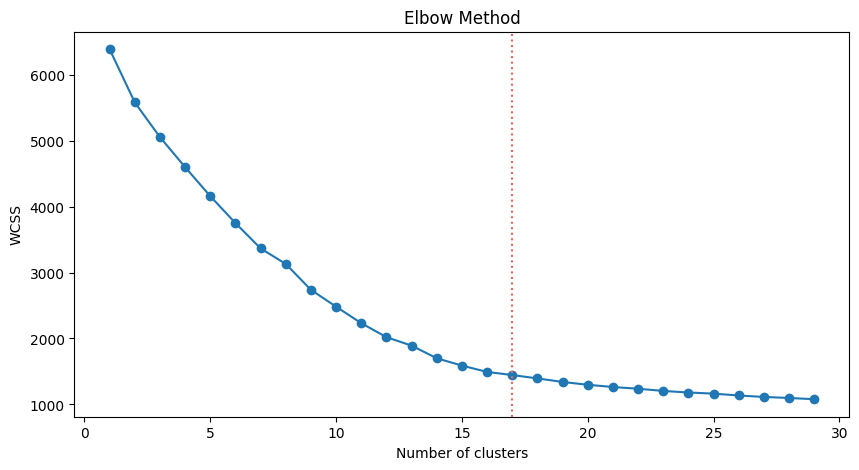

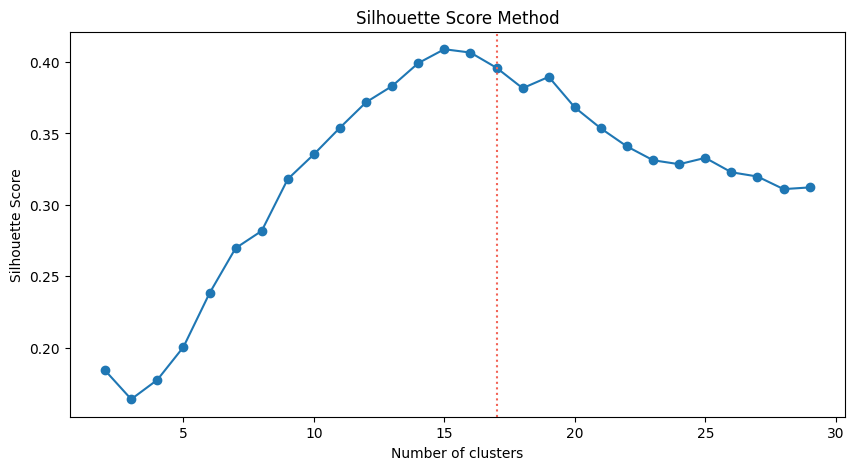

In [265]:
# Using the Elbow Method to identify optimal number of clusters
wcss = []  # Within-cluster sum of squares
k_values = range(1, 30)  

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(doc_topic_matrix)
    wcss.append(kmeans.inertia_)


plt.figure(figsize=(10,5))
plt.plot(k_values, wcss, 'o-')
# Add a vertical line to show the optimum number of clusters 
plt.axvline(17, color='#F26457', linestyle=':')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Using Silhouette Score
sil_scores = []

for k in range(2, 30):  # Silhouette Score is not defined for a single cluster
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(doc_topic_matrix)
    silhouette_avg = silhouette_score(doc_topic_matrix, cluster_labels)
    sil_scores.append(silhouette_avg)

plt.figure(figsize=(10,5))
plt.plot(range(2, 30), sil_scores, 'o-')
plt.axvline(17, color='#F26457', linestyle=':')
plt.title('Silhouette Score Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()


In [266]:
# Choose the number of clusters
k = 17  # For instance, but you might want to determine this using the Elbow Method or other techniques

# Apply K-means clustering
kmeans = KMeans(n_clusters=k, random_state=2023)
df['Cluster'] = kmeans.fit_predict(doc_topic_matrix)

clust_labels = kmeans.predict(doc_topic_matrix)

# The DataFrame now has an additional 'Cluster' column indicating the cluster number for each document
df.head(20).style.applymap(color_green).applymap(make_bold)

,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16,Topic_17,Dominant,Cluster
1.txt,0.445431,0.000052,0.000052,0.000052,0.000052,0.238249,0.000052,0.181255,0.000052,0.000052,0.000052,0.098180,0.036263,0.000052,0.000052,0.000052,0.000052,Topic_1,14
10.txt,0.000049,0.000049,0.000049,0.000049,0.005170,0.000049,0.000049,0.000049,0.000049,0.000049,0.016094,0.000049,0.003915,0.014767,0.947714,0.011803,0.000049,Topic_15,2
100.txt,0.000062,0.000062,0.000062,0.964506,0.000062,0.000062,0.000062,0.000062,0.000062,0.004026,0.000062,0.000062,0.000062,0.030597,0.000062,0.000062,0.000062,Topic_4,16
1000.txt,0.089239,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.297670,0.000198,0.040402,0.570113,0.000198,0.000198,0.000198,0.000198,0.000198,Topic_12,4
10000.txt,0.291969,0.077796,0.000094,0.000094,0.000094,0.000094,0.012161,0.104918,0.000094,0.402380,0.000094,0.057775,0.000094,0.052056,0.000094,0.000094,0.000094,Topic_10,15
10001.txt,0.000095,0.000095,0.000095,0.000095,0.000095,0.213064,0.000095,0.249309,0.000095,0.000095,0.000095,0.478642,0.057745,0.000095,0.000095,0.000095,0.000095,Topic_12,4
10002.txt,0.000115,0.000115,0.820592,0.008063,0.009540,0.000115,0.000115,0.129961,0.000115,0.000115,0.000115,0.000115,0.030460,0.000115,0.000115,0.000115,0.000115,Topic_3,7
10003.txt,0.000079,0.000079,0.310025,0.000079,0.000079,0.138607,0.000079,0.087628,0.000079,0.000079,0.000079,0.458950,0.000079,0.003841,0.000079,0.000079,0.000079,Topic_12,4
10004.txt,0.000016,0.000016,0.000016,0.001176,0.000016,0.008632,0.014312,0.000016,0.698883,0.000016,0.000016,0.000016,0.000016,0.160922,0.115895,0.000016,0.000016,Topic_9,1
10005.txt,0.205827,0.000177,0.000177,0.000177,0.000177,0.103102,0.023938,0.000177,0.160998,0.000177,0.000177,0.000177,0.373045,0.000177,0.108689,0.000177,0.022629,Topic_13,0


In [267]:
df.to_csv('testdata.csv')

In [268]:
fileids = corpus.fileids()
# check number of file ids = number of cluster labels
kmeans_labels = pd.DataFrame(clust_labels)
len(fileids) == len(kmeans_labels)

# append file IDs to cluster labels
fileids_col = pd.Series(fileids, name='FileID')
kmeans_labels['FileID'] = fileids_col

# kmeans_labels = pd.DataFrame(clust_labels)

##### Export visually

In [269]:
import pyLDAvis.gensim_models # Works
pyLDAvis.enable_notebook()

In [270]:
%%time
# Generate the visuals

visual= pyLDAvis.gensim_models.prepare(lda_gen, law_vecs, dictionary)

CPU times: user 35.8 s, sys: 1min 4s, total: 1min 40s
Wall time: 22.7 s


In [271]:
# Save the output to the html file
pyLDAvis.save_html(visual, "topic_viz_clust0_17.html")

- Saving the best LDA model

In [272]:
dump(lda_gen, 'lda_17.joblib')

['lda_17.joblib']

- Loading the best LDA model

## Querying of information

### Create Sparse Matrix Similarity for Corpus first

In [273]:
# To find the similarity scores, create a reverse index
Index = similarities.SparseMatrixSimilarity(law_vecs, len(dictionary))

# Create a TFIDF reveset index
TFIDF = models.TfidfModel(law_vecs)
VectorsWithTFIDF = [TFIDF[vec] for vec in law_vecs]
IndexWithTFIDF = similarities.SparseMatrixSimilarity(VectorsWithTFIDF, len(dictionary))

### Get list of top 10 similar documents

In [274]:
# Tokenize and Vectorize the query document
## I used an unseen document for testing, I verified the top 4 documents in the results against this unseen document and it seems similar enough
text_to_query = '3850.txt'
query = PlaintextCorpusReader('us-supreme-court[raw-cases-22776]',text_to_query, encoding='latin-1') 
query_tokens = preprocessing(query)

# Create a query vector using the same dictionary as the corpus
qVector = docs2vecs(query_tokens, dictionary)

# Get its TFIDF from the same model as the corpus
qVectorTFIDF = TFIDF[qVector]
# print(qVector, qVectorTFIDF)

In [275]:
# Get the similaries from the two indexes (raw and TFIDF)
# simRaw = Index[qVector]
simTFIDF = IndexWithTFIDF[qVectorTFIDF]

# Flatten the array otherwise it doesnt sort correctly
# simRaw_flat = list(chain(*simRaw))
simTFIDF_flat = list(chain(*simTFIDF))

# sort them
# simSorted = sorted(enumerate(simRaw_flat), key = lambda item: -item[1])
simTFIDFSorted = sorted(enumerate(simTFIDF_flat), key = lambda item: -item[1])

In [276]:
# Translate the file ids to filenames
# In the list comprehension, sim is a tuple, and its elements are extracted just like a list
# Note that the output also is a list of tuples, with the first element replaced by the filename
# fRaw = [(corpus.fileids()[sim[0]], sim[1]) for sim in simSorted[0:5]]
fTFIDF = [(corpus.fileids()[sim[0]], sim[1]) for sim in simTFIDFSorted if text_to_query not in corpus.fileids()[sim[0]]][:10]

# Using the * operator, you can use the separator
# print("Search results using RAW scores. (Filename, score):")
# print(*fRaw, sep = '\n')
print("\nSearch results using TFIDF scores. (Filename, score):")
print(*fTFIDF, sep = '\n')


Search results using TFIDF scores. (Filename, score):
('4891.txt', 0.43636736)
('12917.txt', 0.4015394)
('6542.txt', 0.39755785)
('931.txt', 0.39265814)
('1082.txt', 0.37963608)
('445.txt', 0.37508303)
('11860.txt', 0.3623448)
('6942.txt', 0.3570003)
('10930.txt', 0.35337126)
('1604.txt', 0.35132128)


In [277]:
# add in the document clusters
relevant_doc_ids = [t[0] for t in fTFIDF]
relevant_docs_df = df.loc[relevant_doc_ids][[df.columns[-1]]]
relevant_docs_df['rank'] = range(1, len(relevant_docs_df) + 1)
relevant_docs_df

,Cluster,rank
4891.txt,6,1
12917.txt,6,2
6542.txt,3,3
931.txt,3,4
1082.txt,6,5
445.txt,3,6
11860.txt,3,7
6942.txt,3,8
10930.txt,12,9
1604.txt,6,10


### Predict the query's topic and cluster

In [278]:
# Fit query vector into LDA model
query_lda = lda_gen[qVector]

# Fill the matrix with topic probabilities
topic_prob = list(chain(*[topic for topic in query_lda]))

# Convert into a matrix and transpose
query_matrix = np.zeros(lda_gen.num_topics)
for topic, prob in topic_prob:
    query_matrix[topic] = prob

query_matrix = query_matrix.reshape(1, -1)

In [279]:
# predict which cluster the query belongs to
predicted_cluster = kmeans.predict(query_matrix)
print(f"The predicted cluster for the query is: {predicted_cluster}")

The predicted cluster for the query is: [3]


## Evaluation

### 1. Compute AP based on query

In [280]:
def compute_ap(relevant_docs_df, predicted_cluster):
    ap = 0.0
    p = 0.0
    hit_count = 0
    for i, label in enumerate(relevant_docs_df['Cluster']):
        if label == predicted_cluster:
            hit_count += 1
            p += hit_count / (i + 1)
    if hit_count == 0:
        ap = 0 
    else:
        ap = p / hit_count 
    
    return ap

In [281]:
ap = compute_ap(relevant_docs_df, predicted_cluster)
print(f"Average precision for the query is: {ap}")

Average precision for the query is: 0.5059523809523809


### 2. Compute Mean Average Precision across all documents

In [282]:
total_ap = []

for i, tokens in tqdm(enumerate(tokenized_1gram)):
    text_to_query = str(i+1) + '.txt'
    # Create a query vector using the same dictionary as the corpus
    query = PlaintextCorpusReader('us-supreme-court[raw-cases-22776]',text_to_query, encoding='latin-1') 
    query_tokens = preprocessing(query)
    qVector = docs2vecs(query_tokens, dictionary)


    # Get its TFIDF from the same model as the corpus
    qVectorTFIDF = TFIDF[qVector]

    # Get the similaries from the two indexes (raw and TFIDF)
    # simRaw = Index[qVector]
    simTFIDF = IndexWithTFIDF[qVectorTFIDF]
    

    # simRaw_flat = list(chain(*simRaw))
    simTFIDF_flat = list(chain(*simTFIDF))

    # sort them
    # simSorted = sorted(enumerate(simRaw_flat), key = lambda item: -item[1])
    simTFIDFSorted = sorted(enumerate(simTFIDF_flat), key = lambda item: -item[1])
    
    fTFIDF = [(corpus.fileids()[sim[0]], sim[1]) for sim in simTFIDFSorted if text_to_query not in corpus.fileids()[sim[0]]][:10]
    
    # add in the document clusters
    relevant_doc_ids = [t[0] for t in fTFIDF]
    relevant_docs_df = df.loc[relevant_doc_ids][[df.columns[-1]]]
    relevant_docs_df['rank'] = range(1, len(relevant_docs_df) + 1)
    
    # Fit query vector into LDA model
    query_lda = lda_gen[qVector]

    # Fill the matrix with topic probabilities
    topic_prob = list(chain(*[topic for topic in query_lda]))

    # Convert into a matrix and transpose, then get kmeans to predict the correcct cluster
    query_matrix = np.zeros(lda_gen.num_topics)
    for topic, prob in topic_prob:
        query_matrix[topic] = prob

    query_matrix = query_matrix.reshape(1, -1)
    
    predicted_cluster = kmeans.predict(query_matrix)
    
    total_ap.append(compute_ap(relevant_docs_df, predicted_cluster)) 

15000it [34:30,  7.24it/s]


In [283]:
print('The MAP across all 15000 documents is', np.mean(total_ap))

The MAP across all 15000 documents is 0.697125161617116
